<a href="https://colab.research.google.com/github/lethanhnam1203/Machine-Deep-Learning-/blob/main/ResNet_on_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Set Up

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import sampler

## TASK A: 
Read the ResNet paper (yes we did it)

## TASK B: 
Implement the ResNet for an arbitrary value of n using PyTorch.

In [2]:
class Block(nn.Module):
    """
    Each block has 2 layers and follows the structure of:
    convolution -> batch_normalisation -> relu -> convolution -> batch_normalisation -> short_cut -> relu
    """
    def __init__(self, num_filters, subsample=False):
        """
        Input:
        num_filters: int, the number of filters used in each convolution
        subsample: boolean, whether to downsize the image by a factor of 1/2               
        """
        super().__init__()
        stride_value = 2 if subsample else 1
        self.conv1 = nn.Conv2d(in_channels=int(num_filters/stride_value), out_channels=num_filters, kernel_size=3, 
                               stride=int(stride_value), padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=num_filters)
        self.conv2 = nn.Conv2d(in_channels=num_filters, out_channels=num_filters, 
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(num_filters)
        self.relu = nn.ReLU()
        self.downsample = nn.AvgPool2d(kernel_size=1, stride=2)
        # Weight Initialisation
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(module, nn.BatchNorm2d):
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)
                
    def forward(self, x):
        """
        Input: 
        x: tensor, the original input value to the block
        shortcut: boolean, if there is a shortcut step (add the identity map)
        Output:
        out
        """
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if x.shape != out.shape:
            downsize_x = self.downsample(x)
            out += torch.cat((downsize_x, torch.mul(downsize_x, 0)), dim=1)
        else:
            out += x
        out = self.relu(out)
        return out             

In [3]:
class ResNet(nn.Module):
    """
    Implementation of ResNet for an arbitrary n
    """
    def __init__(self, n):
        """
        Complete architecture for the ResNet
        Input:
        n: int, the numer of blocks per ouput map size -> 2n layers
        shortcut: boolean, if there is a shortcut step (add the identity map)
        pool_kernel_size: int, kernel_size of average pooling before the fully connected layer
        """
        super().__init__()
        # the first 3x3 convolution -> 1 layer
        self.conv0 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn0 = nn.BatchNorm2d(num_features=16)
        self.relu = nn.ReLU()
        # Stack1 (size = 32x32) -> 2n layers -> b blocks
        self.stack1 = nn.ModuleList([Block(num_filters=16, subsample=False) for layer in range(n)])
        # Stack2 (size = 16x16)
        self.stack2_downsize = Block(num_filters=32, subsample=True)
        self.stack2 = nn.ModuleList([Block(num_filters=32, subsample=False) for layer in range(n-1)])
        # Stack3 (size = 8x8)
        self.stack3_downsize = Block(num_filters=64, subsample=True)
        self.stack3 = nn.ModuleList([Block(num_filters=64, subsample=False) for layer in range(n-1)])
        # Global Average Pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # Fully Connected Layer
        self.fc = nn.Linear(64, 10, bias=True)
        # Weight Initialization
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight)
                module.bias.data.zero_() 
        #Softmax
        self.softmax = nn.LogSoftmax(dim=-1)
        
    def forward(self, x):
        """
        Input: 
        x: tensor, the original input value to the ResNet
        Output:
        loss (calculated by softmax loss)
        """
        out = self.conv0(x)
        out = self.bn0(out)
        out = self.relu(out)
        for layer in self.stack1:
            out = layer.forward(out)
        out = self.stack2_downsize.forward(out)
        for layer in self.stack2:
            out = layer.forward(out) 
        out = self.stack3_downsize.forward(out)   
        for layer in self.stack3:
            out = layer.forward(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        loss = self.softmax(out)
        return loss

## TASK C: 
Implement data augmentation **"4 pixels are padded on each side, and a 32×32 crop is randomly sampled from the padded image or its horizontal flip. For testing, we only evaluate the single view of the original 32×32 image."**

In [4]:
NUM_TRAIN = 49000

# Set preprocessing and data augmentation parameters. Data normalization
train_transform = transforms.Compose([transforms.Pad(4),
    # 4 pixels are padded on each side  
    transforms.RandomHorizontalFlip(p=0.5), transforms.RandomCrop(32), transforms.ToTensor()])
    # a 32×32 crop is randomly sampled from the padded image or its horizontal flip  

# For testing, we only evaluate the single view of the original 32×32 image
test_transform = transforms.Compose([transforms.ToTensor()])

# Download and splitting data in training, validation and test sets and in batches.
# Taking random samples in a specific range for validation and train data.

cifar10_train = datasets.CIFAR10(root='data', train=True, download=True,
                             transform=train_transform)
loader_train = DataLoader(cifar10_train, batch_size=128, num_workers=2, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = datasets.CIFAR10(root='data', train=True, download=True,
                           transform=train_transform)
loader_val = DataLoader(cifar10_val, batch_size=128, num_workers=2, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = datasets.CIFAR10(root='data', train=False, download=True, 
                            transform=test_transform)
loader_test = DataLoader(cifar10_test, batch_size=128, num_workers=2)


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Validating training sizes
images, labels = next(iter(loader_train))
print(f"images.shape: {images.shape} & labels.shape: {labels.shape}")

images.shape: torch.Size([128, 3, 32, 32]) & labels.shape: torch.Size([128])


In [6]:
def plot_images(images, cls_true, cls_pred=None):
    """
    This function plot images with their labels.
    """
    # CIFAR10 labels
    labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
    fig, axes = plt.subplots(2, 4)
    for i, ax in enumerate(axes.flat):
        # plot imgages
        ax.imshow(images[i, :, :, :], interpolation='spline16')
        # show true & predicted classes
        cls_true_name = labels[cls_true[i]]
        if cls_pred is None:
            xlabel = "{0} ({1})".format(cls_true_name, cls_true[i])
        else:
            cls_pred_name = labels[cls_pred[i]]
            xlabel = "True: {0}\nPred: {1}".format(
                cls_true_name, cls_pred_name)
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

torch.Size([128, 3, 32, 32])


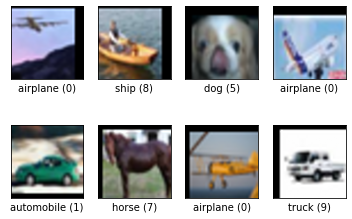

In [13]:
data_iter = iter(loader_train)
images, labels = data_iter.next()
print(images.shape)
X = images.numpy().transpose([0, 2, 3, 1])
plot_images(X, labels)

## TASK E: 
Write a function that counts the parameters of a PyTorch model. How many parameters does the model have?

In [18]:
def count_parameters(model):
    total_params = 0
    for name, param in model.named_parameters():
        if param.requires_grad is True:
          total_params += param.numel()
    return total_params

In [19]:
model = ResNet(n=3)
print(count_parameters(model))

269722


In [20]:
model = ResNet(n=5)
print(count_parameters(model))

464154


In [17]:
#The function below is much nicer, adjusted based on 
#https://stackoverflow.com/questions/49201236/check-the-total-number-of-parameters-in-a-pytorch-model

from prettytable import PrettyTable
def count_parameters(model):
    table = PrettyTable(["Modules", "No. of parameters"])
    total_params = 0
    for name, param in model.named_parameters():
        if param.requires_grad is True: 
          number_of_params = param.numel()
          table.add_row([name, number_of_params])
          total_params+=number_of_params
    print(table)
    print("Total Trainable Parameters:", total_params)
    return total_params

model = ResNet(n=3)  
count_parameters(model)

+------------------------------+-------------------+
|           Modules            | No. of parameters |
+------------------------------+-------------------+
|         conv0.weight         |        432        |
|          bn0.weight          |         16        |
|           bn0.bias           |         16        |
|    stack1.0.conv1.weight     |        2304       |
|     stack1.0.bn1.weight      |         16        |
|      stack1.0.bn1.bias       |         16        |
|    stack1.0.conv2.weight     |        2304       |
|     stack1.0.bn2.weight      |         16        |
|      stack1.0.bn2.bias       |         16        |
|    stack1.1.conv1.weight     |        2304       |
|     stack1.1.bn1.weight      |         16        |
|      stack1.1.bn1.bias       |         16        |
|    stack1.1.conv2.weight     |        2304       |
|     stack1.1.bn2.weight      |         16        |
|      stack1.1.bn2.bias       |         16        |
|    stack1.2.conv1.weight     |        2304  

269722

## TASK D: 
**"Train the model for n= 3 for min 5 epochs using an exponential learning rate decay with γ= 0.95. Make sure min 70% test accuracy."**

Lets try with some code from the last lecture

In [21]:
# Use the GPU when possible

USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)
def train_part34(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    losses = []
    best_accuracy = 0
    best_model = None

    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)
            losses.append(loss.item())

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                validation_accuracy = check_accuracy_part34(loader_val, model)
                print()

                if best_accuracy < validation_accuracy:
                  best_model = model
            
    return losses, best_model

def check_accuracy_part34(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc

using device: cuda


In [22]:
# Validate ResNet model final shape
model = None
model = ResNet(n=3)
x = torch.randn(2, 3, 32, 32)
print(model(x).shape)

torch.Size([2, 10])


In [23]:
# Train ResNet model
learning_rate = 0.1
learning_rate_decay = 0.95 # Not using learning rate decay for only 16 epochs
weight_decay = 0.0001
momentum = 0.9
epochs = 16

model = None
optimizer = None

model = ResNet(n=3)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

# Let's train this monster:
training_losses, best_model = train_part34(model, optimizer, epochs=epochs)

Iteration 0, loss = 4.0595
Checking accuracy on validation set
Got 105 / 1000 correct (10.50)

Iteration 100, loss = 1.8571
Checking accuracy on validation set
Got 254 / 1000 correct (25.40)

Iteration 200, loss = 1.7185
Checking accuracy on validation set
Got 362 / 1000 correct (36.20)

Iteration 300, loss = 1.5374
Checking accuracy on validation set
Got 414 / 1000 correct (41.40)

Iteration 0, loss = 1.4944
Checking accuracy on validation set
Got 434 / 1000 correct (43.40)

Iteration 100, loss = 1.5190
Checking accuracy on validation set
Got 512 / 1000 correct (51.20)

Iteration 200, loss = 1.2929
Checking accuracy on validation set
Got 491 / 1000 correct (49.10)

Iteration 300, loss = 1.2468
Checking accuracy on validation set
Got 531 / 1000 correct (53.10)

Iteration 0, loss = 1.0683
Checking accuracy on validation set
Got 571 / 1000 correct (57.10)

Iteration 100, loss = 1.1722
Checking accuracy on validation set
Got 566 / 1000 correct (56.60)

Iteration 200, loss = 1.2609
Checkin

## TASK F:
Your  network  should  be  able  to  save  and  restore  the  weights.

In [24]:
# Save the best model
PATH =  'best_model.pt'
torch.save(best_model, PATH)

In [25]:
# Load the best model
best_model = torch.load(PATH)
best_model.eval()

ResNet(
  (conv0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (stack1): ModuleList(
    (0): Block(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (downsample): AvgPool2d(kernel_size=1, stride=2, padding=0)
    )
    (1): Block(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False

##TASK G:
Plot the loss curves

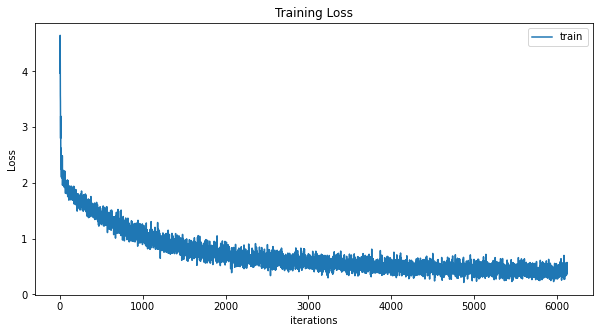

In [26]:
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(training_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [27]:
# Let's check the accuracy of our best model on the test data
check_accuracy_part34(loader_test, best_model)

Checking accuracy on test set
Got 8136 / 10000 correct (81.36)


0.8136